In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm

from collections import defaultdict

import optuna

from sklearn.metrics import accuracy_score, recall_score


/home/james/virtual_envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from reserve import generate_reserve
from MDP_helpers import MDP, valueFunction, valueIteration, relabel_k
from kmdp_toolbox import aStarAbs, sk_to_s

In [3]:
from torch_geometric.data import Data
from torch.utils.data import DataLoader

In [4]:
from experiment import Experiment

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'

In [6]:
# Generate Reserve Data
N_datasets = 100

N_sites = 5
N_species = 20
K = 7

N_states = 3**N_sites
N_actions = N_sites

print(f"Generating {N_datasets} MDPs with {N_states} states and {N_actions} actions \n")

mdp_datasets = []
for i in tqdm(range(N_datasets)):
    pj = np.random.random() # random probability between 0 and 1

    T, R = generate_reserve(N_sites, N_species, pj=pj, seed=i) 
    mdp = MDP(T, R, gamma=0.99)
    mdp.solve_MDP()

    mdp.k_states, mdp.K = aStarAbs(P=mdp.transitions, R=mdp.rewards, V=mdp.optimal_values, policy=mdp.optimal_policy, K=K, precision=1e-6)

    mdp_datasets.append(mdp)

Generating 100 MDPs with 243 states and 5 actions 



100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


In [7]:
dataset = []

for mdp in mdp_datasets:
    # Set up data as graphs with node features defined by rewards and transition probabilities. Approach is to make dataset tabular as set node features
    P = mdp.transitions
    # N_actions, N_states = P.shape[0], P.shape[1]
    T = np.empty((N_states, N_states*N_actions))
    for i in range(27):
        T[i, :] = P[:, i, :].reshape(1, -1)

    x = np.concatenate([T, mdp.rewards], axis=1)

    # Cound whether transition are non-zero for any action
    p_sum = np.sum((P> 0), axis=0)
    edges = [[i, j] for i, j in zip(*np.where(p_sum > 0))]

    # Convert to torch
    x = torch.tensor(x, dtype=torch.float).to(device)
    edges = torch.tensor(edges, dtype=torch.int).T.to(device)

    k = torch.tensor(mdp.k_states, dtype=torch.int64).to(device)

    dataset.append(
        Data(
            x=x,
            edges=edges,
            k_labels=k
        ).to(device)
    )

In [8]:
# dataset = []

# for mdp in mdp_datasets:
#     P = mdp.transitions

#     # Cound whether transition are non-zero for any action
#     p_sum = np.sum((P> 0), axis=0)
#     edges = [[i, j] for i, j in zip(*np.where(p_sum > 0))]

#     # Convert to torch
#     x = torch.tensor(mdp.rewards, dtype=torch.float).to(device)
#     edges = torch.tensor(edges, dtype=torch.int).T.to(device)

#     k = torch.tensor(mdp.k_states, dtype=torch.int64).to(device)

#     dataset.append(
#         Data(
#             x=x,
#             edges=edges,
#             k_labels=k
#         ).to(device)
#     )

In [9]:
data_split = int(len(dataset)*0.8)
train_data = dataset[:data_split]
test_data = dataset[data_split:]

hparam_split = int(len(train_data)*0.8)
train_data_hparam = train_data[:hparam_split]
val_data = train_data[hparam_split:]

In [10]:
# Training
from torch_geometric.nn.models import GCN

In [11]:
def buildKMDP(T: torch.tensor, R: torch.tensor, predicted_k_states: torch.tensor, K: int) -> torch.tensor:
    """ Implement buildKMDP using inbuilt torch functions to keep everything on device """
    K2S = sk_to_s(predicted_k_states, K)
    weights = (1/torch.bincount(predicted_k_states))[predicted_k_states]

    RK = torch.empty(size=(K, N_actions), device=device, dtype=torch.float64)
    # R = torch.tensor(mdp.rewards).to(device)

    TK = torch.empty(size=(N_actions, K, K), device=device, dtype=torch.float64)
    # T = torch.tensor(mdp.transitions).to(device)

    for k in range(K):
        RK[k] = (R.T*weights).T[predicted_k_states==k].sum(axis=0)
        for kp in range(K):
            TK[:, k, kp] = (T[:, :, predicted_k_states==kp].sum(axis=2) * weights)[:, predicted_k_states==k].sum(axis=1)
    return TK, RK, K2S

In [12]:
# value iteration

def valueIteration(T, R, gamma = 0.99, epsilon=1e-4, N_iter=10000):
    """ Implement Value Iteration in the pytorch environment """
    N_states, N_actions = R.shape
    V = torch.zeros(size=[N_states], device=device, dtype=torch.float64)
    Q = torch.empty(size=[N_states, N_actions], device=device, dtype=torch.float64)
    for i in range(N_iter):
        for a in range(N_actions):
            Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V

        V_new, policy = Q.max(axis=1)

        if torch.all(torch.abs(V_new - V) < epsilon):
            break
        
        if i == N_iter - 1:
            raise Exception("Did not converge in time. Consider increasing the number of iterations.")

        V = V_new
    return V_new, policy

In [13]:
def valueFunction(T, R, policy, gamma=0.99, epsilon=1e-3, N_iter = 1e6):
    """ Calculate the value function of an mdp given a policy """
    N_states, N_actions = R.shape
    
    V = torch.zeros(size=[N_states]).to(device)
    V_new = torch.zeros(size=[N_states]).to(device)

    count = 0
    converged=False
    while not converged:
        for s in range(N_states):
            V_new[s] = R[s, policy[s]] + (T[policy[s], s]*V).sum()

        if torch.max(V_new - V) < epsilon:
            converged = True

        V = 1*V_new

        count += 1
        if count >= N_iter:
            print("Did not converge")
            break
        
    return V_new

In [14]:
def calculate_gap(predicted_k_states, K):
    # predicted_k_states = #F.softmax(prediction, dim=1).argmax(axis=1)

    new_K = len(predicted_k_states.unique())
    predicted_k_states = relabel_k(predicted_k_states, K) if new_K != K else predicted_k_states

    T, R, V = torch.tensor(mdp.transitions).to(device), torch.tensor(mdp.rewards).to(device), torch.tensor(mdp.optimal_values).to(device)

    PK, RK, K2S = buildKMDP(T, R, predicted_k_states, new_K)
    VK, kmdp_policy = valueIteration(PK, RK, gamma=0.85, N_iter=50000, epsilon=1e-1)

    k_policy = torch.empty(size=[N_states], dtype=torch.int64).to(device)

    for k in range(new_K):
        k_policy[K2S[k]] = kmdp_policy[k]

    V_K = valueFunction(T, R, k_policy)

    gap = torch.max(torch.abs(V - V_K))
    error = gap/max(V)

    return gap, error


In [15]:
# ChatGPT written
def multiclass_recall_score(y_true, y_pred, average='macro'):
    """
    Calculate the multiclass recall score using PyTorch.

    Parameters:
    - y_true (torch.Tensor): True labels (ground truth).
    - y_pred (torch.Tensor): Predicted labels.
    - average (str): Type of averaging to use for multiclass recall.
        - 'macro' (default): Calculate recall for each class and then take the average.
        - 'micro': Calculate recall globally by considering all instances.
        - 'weighted': Calculate recall for each class and weight them by support.

    Returns:
    - recall (float): The multiclass recall score.
    """
    assert len(y_true) == len(y_pred), "Input arrays must have the same length"

    if average not in ('macro', 'micro', 'weighted'):
        raise ValueError("Invalid 'average' parameter. Use 'macro', 'micro', or 'weighted'.")

    num_classes = len(torch.unique(y_true))
    recall_per_class = []

    for class_label in range(num_classes):
        true_positive = torch.sum((y_true == class_label) & (y_pred == class_label)).item()
        false_negative = torch.sum((y_true == class_label) & (y_pred != class_label)).item()
        recall = true_positive / (true_positive + false_negative + 1e-10)  # Adding a small epsilon to avoid division by zero
        recall_per_class.append(recall)

    if average == 'macro':
        return sum(recall_per_class) / num_classes
    elif average == 'micro':
        total_true_positives = torch.sum((y_true == y_pred) & (y_true == class_label)).item()
        total_false_negatives = torch.sum((y_true != y_pred) & (y_true == class_label)).item()
        return total_true_positives / (total_true_positives + total_false_negatives + 1e-10)
    elif average == 'weighted':
        class_counts = [torch.sum(y_true == class_label).item() for class_label in range(num_classes)]
        total_samples = len(y_true)
        weights = [count / total_samples for count in class_counts]
        weighted_recall = sum([recall_per_class[i] * weights[i] for i in range(num_classes)])
        return weighted_recall

In [16]:
from torch.optim.lr_scheduler import ExponentialLR

In [23]:
N_epochs = 500

k_counts  = 0
for data in train_data:
    k_counts += torch.bincount(data.k_labels)

def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 30, 200)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0, 0.1)
    lr = trial.suggest_float("lr", 1e-2, 10)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 1e-1)
    weight_param = trial.suggest_int("weight_param", 1, 10)

    gamma = trial.suggest_float("gamma", 0, 1)

    gcn_model = GCN(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)


    weights = (k_counts)**(-1/weight_param)
    weights /= weights.sum()

    optimizer = torch.optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = torch.nn.CrossEntropyLoss(weight=weights)
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    gcn_model.train()
    for epoch in range(N_epochs):
        optimizer.zero_grad()     
        loss = 0
        for data in train_data_hparam:
            pred = gcn_model(x = data.x, edge_index=data.edges)
            loss += loss_function(pred, data.k_labels)
        loss.backward()
        optimizer.step()
        lr_sheduler.step()
    
    gcn_model.eval()
    errors = []
    recall = []
    for data in val_data:
        out = gcn_model(x = data.x, edge_index=data.edges)
        pred = F.softmax(out, dim=1).argmax(axis=1)

        _, error = calculate_gap(pred, K)
        errors.append(error.to('cpu'))
        recall.append(
            recall_score(data.k_labels.to('cpu'), pred.to('cpu'), average="macro")
        )
    
    return np.mean(errors) + (1 - np.mean(recall)) # Minimise errors while maximising recall score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params

print(study.best_value)
print(best_params)

[I 2023-10-19 20:48:28,685] A new study created in memory with name: no-name-f965a2da-b43a-44ad-a44f-ec8eac9816d8


[I 2023-10-19 20:48:54,446] Trial 0 finished with value: 1.1414833803368152 and parameters: {'hidden_channels': 77, 'num_layers': 1, 'dropout': 0.0005080362851500375, 'lr': 7.552188117089633, 'weight_decay': 0.011479909881060072, 'weight_param': 1, 'gamma': 0.778395911029808}. Best is trial 0 with value: 1.1414833803368152.
[W 2023-10-19 20:49:16,135] Trial 1 failed with parameters: {'hidden_channels': 145, 'num_layers': 1, 'dropout': 0.04527074463061623, 'lr': 1.0980013477227826, 'weight_decay': 0.00397112913120772, 'weight_param': 5, 'gamma': 0.8164370476939128} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/james/virtual_envs/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_57218/1008937727.py", line 38, in objective
    pred = gcn_model(x = data.x, edge_index=data.edges)
  File "/home/james/virtual_envs/venv/lib/python3.10/site-package

KeyboardInterrupt: 

In [ ]:
import pandas as pd
trials = [i for i in map(lambda x: dict([("score", x.values[0]),*(x.params).items()]), study.get_trials())]
trials = pd.DataFrame(trials)

score	hidden_channels	num_layers	dropout	lr	weight_decay	weight_param	gamma
21	0.403245	67	1	0.051031	4.809483	0.045045	8	0.972926
20	0.403374	63	1	0.003532	4.839212	0.040630	8	0.989183
14	1.023662	19	1	0.295559	5.025916	0.053842	7	0.798589

In [35]:
trials.sort_values(by="score")

,score,hidden_channels,num_layers,dropout,lr,weight_decay,gamma
24,0.435857,177,1,0.092646,1.082537,0.089716,0.990068
23,0.440945,197,1,0.091764,1.165198,0.098211,0.986790
18,0.444298,182,1,0.086584,2.857201,0.099780,0.988653
29,0.925210,199,1,0.078344,2.158560,0.096597,0.862458
21,0.942085,190,1,0.088420,1.346484,0.089332,0.908428
0,0.946464,194,1,0.081029,2.494742,0.099444,0.868870
20,0.969535,183,1,0.086345,1.459306,0.083234,0.910123
15,1.078424,170,1,0.075449,4.470610,0.086864,0.832975
22,1.088230,185,1,0.087414,2.929600,0.092178,0.909755
13,1.117227,166,1,0.070538,3.850906,0.060855,0.828843


In [5]:
experiment = Experiment(savefile="hparams")

In [ ]:
for i in trials.index:
    trials.loc[i].to_dict()
    experiment.save(trials.loc[i].to_dict())

In [36]:
best_params = trials.loc[24]

In [37]:
best_params['weight_param'] = 10
best_params = best_params.to_dict()

/tmp/ipykernel_57218/355773331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_params['weight_param'] = 10
/tmp/ipykernel_57218/355773331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_params['weight_param'] = 10


In [38]:
best_params

{'score': 0.4358570534022619,
 'hidden_channels': 177.0,
 'num_layers': 1.0,
 'dropout': 0.09264598970849014,
 'lr': 1.0825370546000228,
 'weight_decay': 0.08971584798256982,
 'gamma': 0.9900683399893949,
 'weight_param': 10.0}

{'score': 0.4358570534022619,
 'hidden_channels': 177.0,
 'num_layers': 1.0,
 'dropout': 0.09264598970849014,
 'lr': 1.0825370546000228,
 'weight_decay': 0.08971584798256982,
 'gamma': 0.9900683399893949,
 'weight_param': 10.0}

In [39]:
results = defaultdict(list)

gcn_model = GCN(
    in_channels=int(dataset[0].x.shape[1]), 
    out_channels=K, 
    hidden_channels=int(best_params['hidden_channels']), 
    num_layers=int(best_params['num_layers']), 
    dropout=best_params['dropout']
).to(device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

weights = (k_counts)**(-1/best_params['weight_param'])
weights /= weights.sum()

loss_function = torch.nn.CrossEntropyLoss(weight=weights)
lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=best_params['gamma'])

epoch = 0

In [40]:
N_epochs = 500

epochs = tqdm(range(epoch, N_epochs))
for epoch in epochs:
    gcn_model.train()
    optimizer.zero_grad()

    total_gap = 0
    total_error = 0
    total_loss = 0

    for data in train_data:
        pred = gcn_model(
            x=data.x,
            edge_index=data.edges
        )

        total_loss += loss_function(pred, data.k_labels)

        pred_k = F.softmax(pred, dim=1).argmax(axis=1)
        recall_score(data.k_labels.to('cpu').detach().numpy(), pred_k.to('cpu').detach().numpy(), average="macro")

        gap, error = calculate_gap(pred_k, K)
        total_gap += gap
        total_error += error

    total_loss /= len(train_data)
    total_loss.backward()
    optimizer.step()
    lr_sheduler.step()


    total_gap /= len(train_data)
    total_error/=len(test_data)

    results['training_loss'].append(total_loss.to('cpu').detach().float())
    results['training_gap'].append(total_gap.to('cpu').detach().float())

    gcn_model.eval()
    total_gap = 0
    total_error = 0
    total_loss = 0
    for data in test_data:
        pred = gcn_model(
            x=data.x,
            edge_index=data.edges
        )

        total_loss += loss_function(pred, data.k_labels)

        pred_k = F.softmax(pred, dim=1).argmax(axis=1)
        gap, error = calculate_gap(pred_k, K)
        total_gap += gap
        total_error += error

    total_gap /= len(train_data)
    total_error/=len(test_data)

    total_loss /= len(test_data)

    results['test_loss'].append(total_loss.to('cpu').detach().float())
    results['testing_gap'].append(total_gap.to('cpu').detach().float())


    epochs.set_description(f"{epoch+1}/{N_epochs}, Loss {total_loss:.4f}")

391/500, Loss 1.6362:  78%|███████▊  | 391/500 [56:01<15:36,  8.60s/it]


KeyboardInterrupt: 

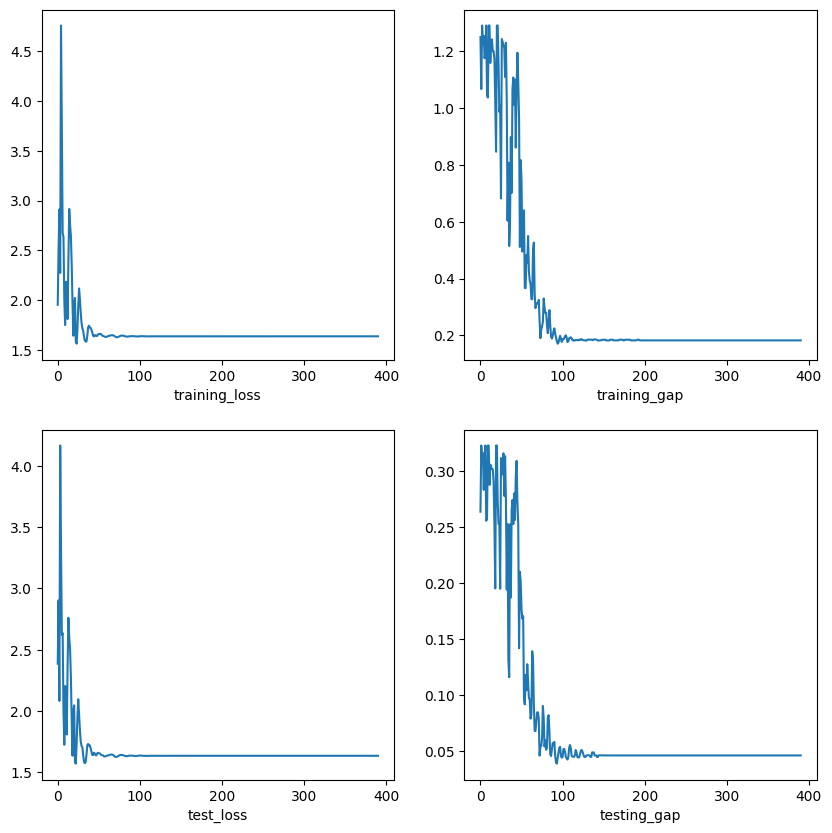

In [41]:
ncols = 2
nrows = len(results) - len(results)//2

if nrows > 1:
    fig, ax = plt.subplots(ncols=2, nrows=nrows, figsize=(10, 5*nrows))

    count = 0
    for result in results:
        row = count//2
        col = count%2
        count += 1

        ax[row][col].plot(results[result])
        ax[row][col].set_xlabel(result)

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame(results).applymap(lambda x: x.numpy()).to_csv(f"results_{N_states}_{N_actions}_wot.csv")

In [44]:
results['testing_gap']

[tensor(0.2638),
 tensor(0.3229),
 tensor(0.3083),
 tensor(0.3162),
 tensor(0.2833),
 tensor(0.3093),
 tensor(0.3229),
 tensor(0.2556),
 tensor(0.2576),
 tensor(0.3229),
 tensor(0.3229),
 tensor(0.2877),
 tensor(0.3058),
 tensor(0.3039),
 tensor(0.3019),
 tensor(0.3016),
 tensor(0.2904),
 tensor(0.2527),
 tensor(0.1954),
 tensor(0.3229),
 tensor(0.3229),
 tensor(0.2725),
 tensor(0.2529),
 tensor(0.2530),
 tensor(0.1951),
 tensor(0.3117),
 tensor(0.2969),
 tensor(0.3060),
 tensor(0.3159),
 tensor(0.2779),
 tensor(0.3132),
 tensor(0.2742),
 tensor(0.1943),
 tensor(0.2529),
 tensor(0.1318),
 tensor(0.1161),
 tensor(0.2525),
 tensor(0.1872),
 tensor(0.2656),
 tensor(0.2743),
 tensor(0.2527),
 tensor(0.2801),
 tensor(0.2564),
 tensor(0.2953),
 tensor(0.3091),
 tensor(0.2718),
 tensor(0.2529),
 tensor(0.1419),
 tensor(0.2103),
 tensor(0.2014),
 tensor(0.1766),
 tensor(0.1683),
 tensor(0.1706),
 tensor(0.0970),
 tensor(0.0919),
 tensor(0.1182),
 tensor(0.1044),
 tensor(0.1278),
 tensor(0.1119